![title](logo.PNG)

# XBeach basic course

*2021*
*Delft, 
Netherlands*


## 1	GETTING STARTED
The course materials contain the XBeach executable, manual, model examples and Deltares software (Quickin, Quickplot) that will help us to analyze and modify the model schematization and results. 

The objectives of this exercise are to learn how to create an XBeach-surfbeat model from scratch to simulate nearshore hydro- and morphodynamics during storm conditions.

Click here to go to the manual:
<a href="https://xbeach.readthedocs.io/en/latest/user_manual.html" target="_blank">Manual</a>

Click here to go to the OSS website:
<a href="https://oss.deltares.nl/web/xbeach/" target="_blank">Manual</a>

## 2	Using the xbTools (Python)
In the following exercises we will make use of the Python routines that are part of the xbTools. The xbTools can be used to set up and run an XBeach model, as well as to analyze and visualize simulation results. The toolbox is open source (like XBeach) and can be downloaded freely. The only requirement is to have Python installed on your pc (preferably version 3.1 or higher).

The toolbox is available in the OpenEarth Github page (<a href="https://github.com/openearth/xbeach-toolbox" target="_blank">xbTools</a>). 

Note that the toolbox is not complete yet.


## 3	HANDS-ON EXERCISE: Storms at Boscombe Beach

In this exercise, we will set up a storm impact model from scratch with use of the xbTools. The case concerns Boscombe beach, located at the south coast of the U.K, and we will use (measured) data of the local bathymetry, hydrodynamic conditions and some other characteristics to set up a storm impact model. 

By follwing the steps in this notebook, we will setup an XBeach model. 

All the required steps to setup a XBeach model are shown in the notebook cells (indicated by `In []`). The code in these cells can be adjusted if desired. To run a cell in the notebook you can press `Shift+enter`. The result of the cell is shown below the cell. Sometimes it takes some time to execute the command in the cell. When the command is executed this is shown with an Astrix before the cell ( `In [*]`). The cell indicated with a `In []` are not yet executed. When a cell is executed, the number of times it is executed is shown before the cell `In [4]`. 

Try it yourself in the cell below, for example, by printing hello xbeach user (`print('hello xbeach user')`).



***
### 1. Import packages
Before we can use the xbTools we need to import a few packages. 

Next to the standard packages, we also need to import the xbTools.

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os

## import xbeach tools
sys.path.append('../../../xbeach-toolbox')

from xbTools import xgrid, ygrid, seaward_extend, XBeachModelSetup, offshore_depth, lateral_extend, xb_run_script_win




***
### 2. set input

Specify the name of your model and set the path of the simulation. In addition set the wave conditions. 

In [2]:
path_sim = os.path.join('models')
simName  = 'test' #REPLACE BY ...

Hm0 = 3
Tp = 15


***
### 3. load data

Load the bathymetric data and plot the bathymetry. The dimensions of the bathymetric data is 124 x 20 points with a cross-shore resolution of 5m and a longshore resolution of 20m. Run the following code to plot the bathymetric data.

**Questions:**
* **What is the height of dunes?**

* **What is the water depth at the offshore boundary?**


/tmp/ipykernel_13299/3688516129.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolor(x,y,bathy)
/tmp/ipykernel_13299/3688516129.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_13299/3688516129.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax      = Axes3D(fig)


Text(0.5, 0.5, 'y [m]')

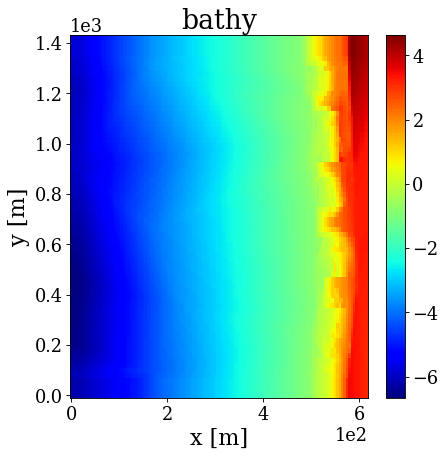

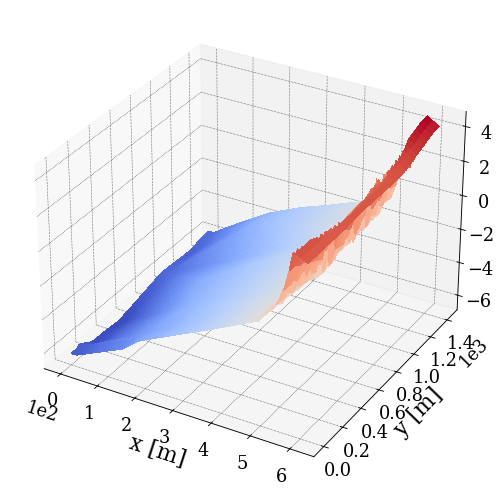

In [3]:
## load data
bathy = np.loadtxt(os.path.join('models','bathy.dep'))

## set bathy grid
nx = 124
ny = 72
dx = 5
dy = 20

x = np.linspace(0,(nx-1)*dx,nx)
y = np.linspace(0,(ny-1)*dy,ny)

X, Y = np.meshgrid(x,y)

## plot
plt.figure()
plt.pcolor(x,y,bathy)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('bathy')



fig     = plt.figure()
ax      = Axes3D(fig)
surf    = ax.plot_surface(X, Y, bathy, cmap=cm.coolwarm,  linewidth=0, antialiased=False)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

***
### 4. xgrid

The bathymetric data does not have the optimal resolution for a XBeach computation. The required grid resolution in the cross-shore direction is related to the wave length. To optimize the computational time, we will create a spatially varying x-grid. The `xgrid` function can help us with creating a x-grid.

We will use one of the profiles from the bathymetric data to create a x-grid. In this example, we will use a minimum dx of 2 m with 20 points per wave length. Note that this function has more input parameters. To see the other input parameters or the function description select the function and click on `SHIFT+TAB` to get the function description.



Text(0, 0.5, 'z [m]')

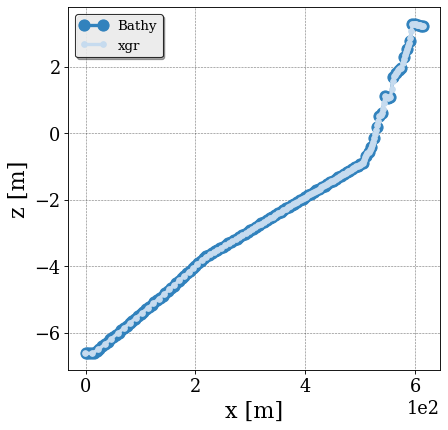

In [4]:
xgr_1D,zgr_1D = xgrid(x, bathy[20,:],dxmin=2,ppwl=20)



plt.figure()
plt.plot(x,bathy[20,:],'-o')
plt.plot(xgr_1D,zgr_1D,'.-')
plt.legend(['Bathy','xgr'],loc=2)
plt.xlabel('x [m]')
plt.ylabel('z [m]')

***
### 5. ygrid

Next to a x-grid, we also need a y-grid. To optimize the computational time, we use a finer grid (dy=5 m) resolution in the center of the domain. To create ay-grid we can use the `ygrid` function.

Enable optimization of transition distance
Area type center
Transition 142.0


/home/seth/sourcecode/_courses/XBeach-Course/Lessons/Python/BoscombeBeach/../../../xbeach-toolbox/xbTools/xbeachtools.py:528: RuntimeWarning: overflow encountered in power
  Lj[1] = cell1 * np.sum(np.power(fj[1],np.arange(1,ni+1,1)) )
/home/seth/sourcecode/_courses/XBeach-Course/Lessons/Python/BoscombeBeach/../../../xbeach-toolbox/xbTools/xbeachtools.py:529: RuntimeWarning: overflow encountered in double_scalars
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
/home/seth/sourcecode/_courses/XBeach-Course/Lessons/Python/BoscombeBeach/../../../xbeach-toolbox/xbTools/xbeachtools.py:529: RuntimeWarning: overflow encountered in power
  Lj[2] = cell1 * np.sum(np.power(np.mean(fj),np.arange(1,ni+1,1)) )
/home/seth/sourcecode/_courses/XBeach-Course/Lessons/Python/BoscombeBeach/../../../xbeach-toolbox/xbTools/xbeachtools.py:519: RuntimeWarning: overflow encountered in double_scalars
  fj[1] = 1.1 * fj[1]


Text(0, 0.5, 'dy [m]')

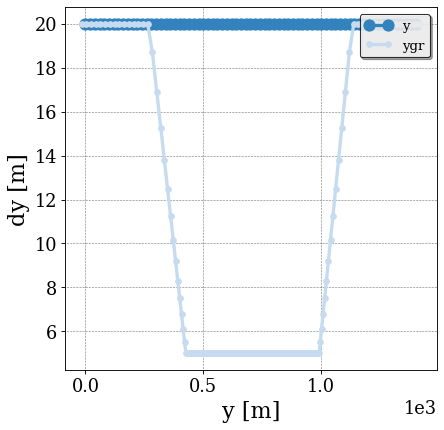

In [5]:
ygr_1D = ygrid(y,dymin=5, dymax= 20, area_size = 0.4)

plt.figure()
plt.plot(y[:-1],np.diff(y),'-o')
plt.plot(ygr_1D[:-1],np.diff(ygr_1D),'.-')
plt.legend(['y','ygr'])
plt.xlabel('y [m]')
plt.ylabel('dy [m]')

***
### 6. interpolate

Now we have created a x and y grid, we need to interpolate the bathymetric data to this new grid. We use the `interpolate` function from t6he scipy package to help us.

/tmp/ipykernel_13299/3397962965.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolor(xgr_1D,ygr_1D,zgr)
/tmp/ipykernel_13299/3397962965.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


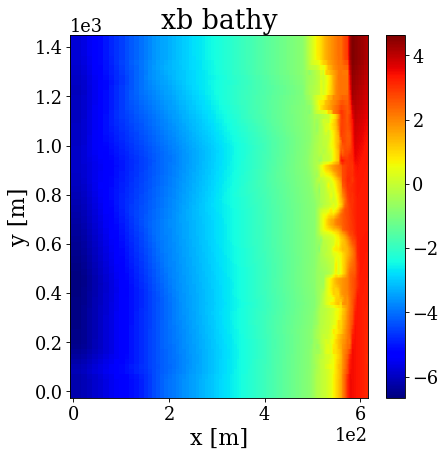

In [6]:
f = interpolate.interp2d(x, y, bathy, kind='linear')

zgr = f(xgr_1D,ygr_1D)

plt.figure()
plt.pcolor(xgr_1D,ygr_1D,zgr)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('xb bathy')
plt.colorbar()

xgr, ygr = np.meshgrid(xgr_1D,ygr_1D)

***
### 7. Seaward extend

To correctly force XBeach, a certain water depth at the boundary is required. The function `offshore_depth` compute the required water depth at the boundary based on the wave conditions.

We will use 1:20 slope to extend the domain to the required water depth.

**Questions:**
* **What is the required water depth?**



Artificial slope of 1:10
Hm0,shoal = 4.042410322276435
d start = 13.498368534933046
Hm0,shoal/d profile = 0.6072284306852537
Hm0,shoal/d slope = 0.2994739928617963
n profile = 0.528623321235569
n slope = 0.6211590418262709


/tmp/ipykernel_13299/1735504906.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolor(xgr,ygr,zgr)
/tmp/ipykernel_13299/1735504906.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


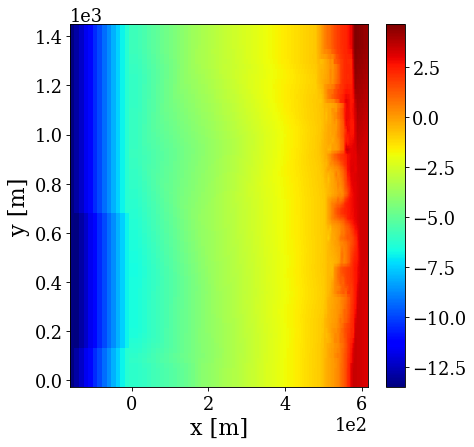

In [7]:
waterdepth = np.abs(bathy[:,0].min())

d_start, slope, Hm0_shoal = offshore_depth(Hm0=Hm0, Tp=Tp, depth_offshore_profile=waterdepth, depth_boundary_conditions=20)

xgr, ygr, zgr = seaward_extend(xgr,ygr,zgr,slope=1/20,depth=d_starpath_simt*-1)

plt.figure()
plt.pcolor(xgr,ygr,zgr)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()

***
### 8. Lateral extend

We will also extend the model domain at both later sides. This is required for the lateral boundary conditions.

In this case, we will extend the domain with 5 additional cells.



/tmp/ipykernel_13299/1425694519.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolor(xgr,ygr,zgr)


Text(0, 0.5, 'y [m]')

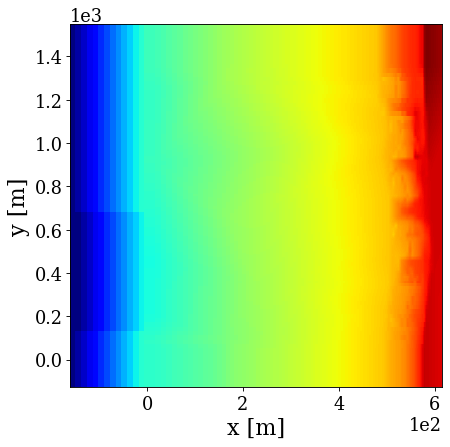

In [8]:
xgr,ygr,zgr = lateral_extend(xgr,ygr,zgr,n=5)

plt.figure()
plt.pcolor(xgr,ygr,zgr)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

***
### 9. Settings

The grid is now finished. The next step is to create an xbeach model. We can use the `XBeachModelSetup` class to create an XBeach model. 

We will give our XBeach model a name and add the grid.

**Questions:**
* **What are the dimensions of the grid?**

In [9]:
xb_setup = XBeachModelSetup(simName)

print(xb_setup)

xb_setup.set_grid(xgr,ygr,zgr)

print('Number of cells in x-direction',xb_setup.nx)

test
Number of cells in x-direction 163


***
### 10. Boundary conditions

XBeach has multiple options to force the boundary conditions. In this example we will use the jons option with a constant wave condition in time.

In [22]:
# xb_setup.set_waves('jons',{'Hm0':Hm0,'Tp':Tp,'gammajsp':3.3, 's' : 10000, 'mainang':270,'fnyq':1})

xb_setup.set_waves('jonstable',{'Hm0':[1.5, 2, 1.5],'Tp':[4, 5, 4],'gammajsp':[3.3, 3.3, 3.3], 's' : [20,20,20], 'mainang':[270,280, 290],'duration':[3600, 3600, 3600],'dtbc':[1,1,1]})


***
### 11. Settings

The last step is to specify the settings of the model.

When a parameter is not specified, XBeach will use the default values. Some key parameters are required for a simulation and must be specified (e.g. wavemodel).


In [23]:
xb_setup.set_params({'Wavemodel':'surfbeat',
                     'morphology':1,
                     'befriccoef':0.01,
                     'tstop':3700,
                     'nglobalvar':['zb','zs','H'],
                     'morfac':5,
                     'tstart':0,
                     'morstart':100,
                     'npointvar':['zs','H'],
                     'nmeanvar':['zb'],
                     'npoints':['1 0', '6 0', '10 0', '12 0']})

***
### 12. Write model

Now the model setup is ready and we can write the model setup to the model folder. In addition, we also write a run script to start the simulation.

To start the simulation go to the model folder and click on the run script.

Note that is also possible to create a batch script with multiple simulations. Instead of the xb_setup class, give a list with different classes as input to the function xb_run_script_win.

models/run0.bat


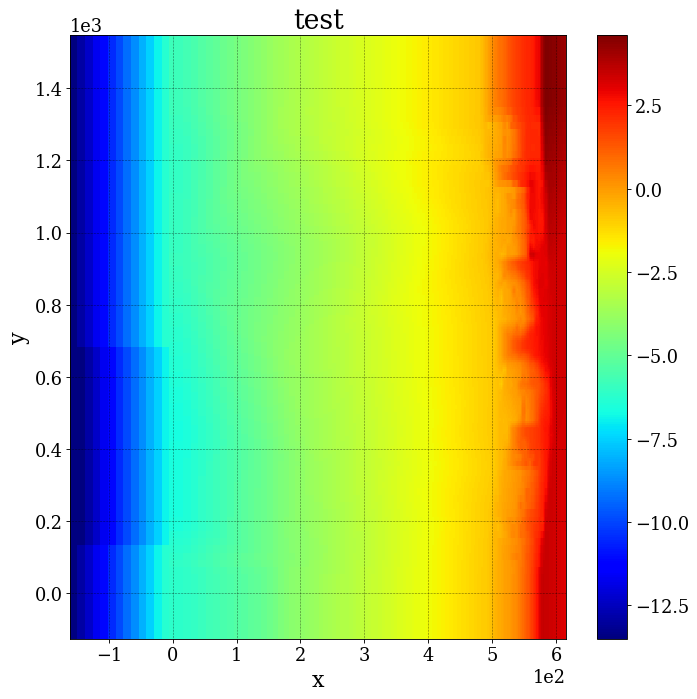

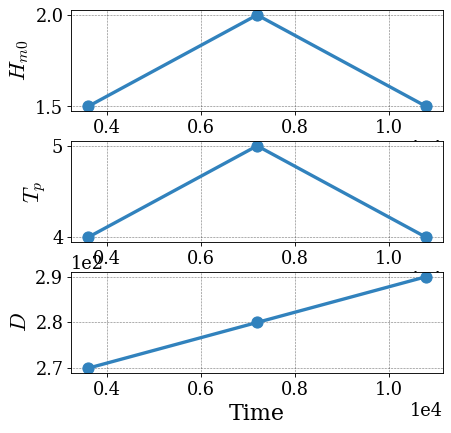

In [24]:
model_path = os.path.join(path_sim,simName)
if not os.path.exists(model_path):
    os.mkdir(model_path)
xb_setup.write_model(model_path)

xb_run_script_win(xb_setup, N=1, maindir=path_sim, xbeach_exe='..\\exe_nonh\\xbeach.exe')

## Exercises

After setting up a model, it is time to try different variations and see how the model behaves. 

Tip: make sure that every simulation has a different name. 

**Questions:**
* **What is the effect of the water level on the dune erosion?**
* **What is the effect of the points per wave length on the grid resolution?**
* **What is the effect of the wave direction on dune erosion**